# Домашняя работа 2. KNN

*Дедлайн: 6 октября, 21:00*

### Оценивание и штрафы

Максимальная оценка - 5 баллов.

Не списывайте, иначе всем участникам обнулим :)

In [38]:
import numpy as np
import matplotlib.pyplot as plt

### Часть 1. Мой KNN 👒

**Задание 1.1 (2 балла)** Реализуйте свой собственный класс для KNN. Сделайте возможность выбора метрики расстояния: евклидова или манхэттанская (это все — частные случаи метрики [Минковского](https://ru.wikipedia.org/wiki/Расстояние_Минковского)).


In [39]:
from collections import Counter
from sklearn.base import BaseEstimator

In [40]:
class KNNClassifier(BaseEstimator):
    def __init__(self, n_neighbors: int = 5, p: int = 2) -> None:
        """
        Attributes
        ------
        n_neighbors: int, default=5
            Number of neighbors to use.

        p: int, default=2
            Power parameter for the Minkowski metric. When p = 1, this is
            equivalent to using manhattan_distance (l1), and euclidean_distance
            (l2) for p = 2.
        """
        self.n_neighbors = n_neighbors
        self.p = p

    def fit(self, X: np.ndarray, y: np.ndarray): 
        """
        Fit the k-nearest neighbors classifier from the training dataset.

        Parameters
        ----------
        X: matrix of shape (n_samples, n_features)
            Training data.
        y: array of shape (n_samples,) 
            Target values.

        Returns
        -------
        self : KNNClassifier
            The fitted k-nearest neighbors classifier.
        """
        self.X_train = X
        self.y_train = y
        
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predict the class labels for the provided data.
        
        Parameters
        ----------
        X: matrix of shape (n_test_samples, n_features)
            Test samples.

        Returns
        -------
        y: array of shape (n_test_samples,) 
            Predicted class labels for each data sample.
        """
        p_matrix = np.sum(np.abs((X[None, :] - self.X_train[:, None]))**self.p, axis = 2)**(1/self.p)
        neighbors = np.apply_along_axis(lambda x: sorted(x, reverse=False)[:self.n_neighbors], 0, p_matrix)
        indices_neighbors = np.sum(p_matrix == neighbors[:, None], axis = 0)
        return np.apply_along_axis(lambda x: Counter(self.y_train[x==1]).most_common(1)[0][0], 0, indices_neighbors)
    
    
    def get_params(self, deep = True):
        return {"n_neighbors" : self.n_neighbors, "p" : self.p}
    
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

**Задание 1.2 (1  балл)** 
Обучите свой KNN для предсказания наличия болезни сердца. Данные лежат [здесь](https://github.com/AsyaKarpova/ml_nes_2020/blob/master/homeworks/heart_hw3.csv).


Описание данных:

- age - age in years

- sex - (1 = male; 0 = female)

- cpchest - pain type

- trestbpsresting - blood pressure (in mm Hg on admission to the hospital)

- cholserum - cholestoral in mg/dl

- fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)

- restecg - resting electrocardiographic results

- thalach - maximum heart rate achieved

- exang - exercise induced angina (1 = yes; 0 = no)

- oldpeak - ST depression induced by exercise relative to rest

- slope - the slope of the peak exercise ST segment

- ca - number of major vessels (0-3) colored by flourosopy

- thal - 3 = normal; 6 = fixed defect; 7 = reversable defect

- target - the presence of heart disease in the patient (**u should predict**)



С помощью кросс-валидации (можно использовать, например, `GridSearchCV`) подберите оптимальное для этой задачи число соседей и метрику расстояния. 
Оцените качество алгоритма с лучшим набором гиперпараметров с помощью `sklearn.model_selection.cross_val_score`, в качестве метрики используйте `accuracy` (`scoring=accuracy`).

In [41]:
# your code
import pandas as pd
url = "https://raw.githubusercontent.com/AsyaKarpova/ml_nes_2020/master/homeworks/heart_hw3.csv"
df = pd.read_csv(url)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [42]:
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

В дополнении к классификатору я использую ```StandardScaler```, чтобы отнормировать данные, так как в этой модели используются расстоянния, то нужно все привести к "одному масштабу", иначе одни переменные будут важнее других.

In [43]:
X, y = df.to_numpy()[:,:-1], df.to_numpy()[:,-1].flatten()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
estimator = Pipeline([('scaler',  StandardScaler()),
            ('KNN', KNNClassifier())])

In [44]:
grid = GridSearchCV(estimator, param_grid={"KNN__n_neighbors" : np.arange(1, 100), "KNN__p" : [1, 2]}, scoring="accuracy", cv = 2)
grid.fit(X_train, y_train)

GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('KNN',
                                        KNNClassifier(n_neighbors=5, p=2))],
                                verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'KNN__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87,

In [45]:
print(grid.best_params_)
print(grid.best_score_)

{'KNN__n_neighbors': 5, 'KNN__p': 1}
0.8140495867768595


In [46]:
accuracy_score(grid.predict(X_test), y_test)

0.8360655737704918

В результате работы ```GridSearchCV``` я нашел лучшие гиперпараметры классификатора: ```n_neighbors = 5``` и ```p = 1```. Без кросс валидации итоговая точность модели на тесте получена выше.

In [47]:
grid.best_estimator_

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('KNN', KNNClassifier(n_neighbors=5, p=1))],
         verbose=False)

In [48]:
np.mean(cross_val_score(grid.best_estimator_, X_test, y_test, cv = 3, scoring = "accuracy"))

0.8515873015873016

В среднем при кросс валидации точность выше. В целом, я думаю, что кросс валидация здесь лишняя, так как изначальный датасет очень маленький - всего 300 строчек. Я оставил 20% на валидацию и кросс валидировал всего на 3 фолда, но, кажется, что давать оценку модели по 20 объектам - это не лучшая идея.

### Часть 2. Мой Робот <имя> 👒

В этом задании мы рассмотрим упрощённую идею того, как метод ближайших соседей можно применить при моделировании движения робота. 

Рассмотрим робота на дискретной двумерной плоскости, который за каждый момент дискретного времени может передвинуться на одну позицию вправо, влево, вверх или вниз. На плоскости разбросаны метки одного из четырёх классов, анализируя которые робот может (но не обязан) корректировать своё перемещение. Пусть метки класса 0 соответствуют сигналу переместиться вправо, метки класса 1 – влево, класса 2 – вверх, класса 3 – вниз. 

Передвижение робота осуществляется по следующему правилу: с вероятностью 0.2 робот передвинется вправо, а с вероятностью 0.8 – оценит, метки какого класса преобладают среди `k` его ближайших соседей, и передвинется в направлении, на которое указывает доминирующий класс. 

Для лучшего понимания происходящего изобразим возможное положение робота и меток:

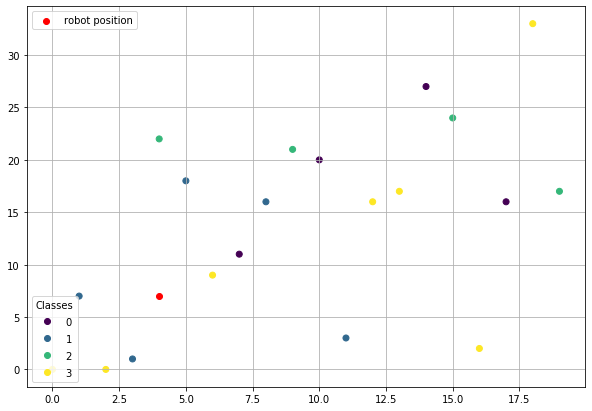

In [49]:
np.random.seed(12345)
x = np.arange(20)
landmarks = x + np.round(np.random.normal(2, 8, 20)) #сгенерируем случайные метки
random_classes = np.random.randint(0, 4, 20)

fig, ax = plt.subplots(figsize = (10, 7))
scatter = ax.scatter(x, landmarks, c = random_classes)
ax.scatter(4, 7, c = 'r', marker = 'o', label = 'robot position')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc = "lower left", title = "Classes")
ax.add_artist(legend1)

plt.plot()
_ = plt.legend()
_ = plt.grid()

На следующем шаге робот передвинется на единичку либо вправо, либо в направлении, которое указывают ближайшие соседи.

**Задание 2.1 (1.5 балла)** Реализуйте класс, который задаёт описанное поведение робота, используя шаблон ниже:
1. Определите атрибуты `trajectory` (переменная для хранения истории перемещения робота в виде последовательности точек с двумя координатами) и `knn` (обученный kNN классификатор, который по позиции метки предсказывает её класс).
2. Определите метод `move()`: рассчитайте новое положение робота по правилам выше и добавьте его в историю перемещений. 

Подсказка: исходы можно интерпретировать как результаты подбрасывания монетки с вероятностью орла, равной 0.2. Для моделирования такого подбрасывания можно использовать, например, `np.random.binomial()` с правильными параметрами.


3. Внутри этого класса вы можете использовать свою реализацию kNN (если уверены, что она норм) либо реализацию из sklearn.

In [50]:
from sklearn.neighbors import KNeighborsClassifier

In [51]:
class MobileRobot:
    def __init__(self, k: int, initial_position: np.ndarray, 
                 landmarks: np.ndarray, 
                 classes: np.ndarray) -> None:
        """
        Attributes
        ------
        k: int
            Number of neighbours
            
        initial_position: ndarray
            Initial position of the robot as a point, e.g. (-1, 1)
            
        landmarks: ndarray
            numpy array of shape (n_landmarks, 2) with the euclidean positions of points
        
        classes: ndarray
            numpy array of shape (n_landmarks,) with class of landmark for each point in landmarks
        
        """
        # Store the history of movements
        self.trajectory = np.array([initial_position])
    
        # Fitted kNN Classifier for determining the classes of landmarks
        self.knn = KNeighborsClassifier(n_neighbors=k)
        self.knn.fit(landmarks, classes)
        
        # Mapping between classes of points and movements
        self.mapping = {0: np.array([1, 0]), 
                        1: np.array([-1, 0]),
                        2: np.array([0, 1]),
                        3: np.array([0, -1])}
        
    def move(self) -> None:
        """
        Calculate new position of the robot and add it to the history
        """
        position = None
        last_point = self.trajectory[-1, :]
        
        if(np.random.binomial(n = 1, p = 0.2)):
            position = last_point + self.mapping[0]
        else:
            label = self.knn.predict([last_point])[0]
            position = last_point + self.mapping[label]
            
            
        self.trajectory = np.append(self.trajectory, position[None, :], axis = 0)
            

**Задание 2.2 (0.5 балла)** Дополните функцию `conduct_experiment`: определите переменную `traj` так, чтобы она содержала историю перемещения робота в виде двумерного массива numpy, в котором столбцы соответствуют координатам x и y соответствующей позиции.

In [52]:
def conduct_experiment(x,
                       mean=0,
                       std=2, 
                       n_movements=10, 
                       k=3, 
                       initial_position=np.array([10, 20])):
    
    np.random.seed(12345)
    # Generate random landmarks
    landmarks = np.vstack((x, x + np.round(np.random.normal(mean, std, len(x))))).T
    
    # Generate random classes of landmarks
    classes = np.random.randint(0, 4, size = len(x))
    
    # Conduct experiment
    robot = MobileRobot(k, initial_position, landmarks, classes)
    
    for n in range(n_movements):
        robot.move()
    
    fig, ax = plt.subplots(figsize = (10, 8))
    scatter = ax.scatter(landmarks[:, 0], landmarks[:, 1], c = classes)
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="lower left", title="classes")
    ax.add_artist(legend1)
    
    traj = robot.trajectory
    ax.plot(traj[:, 0], traj[:, 1], 
               c = 'r', marker = 'o', label = 'robot position')

    plt.plot()
    _ = plt.legend()
    _ = plt.grid()

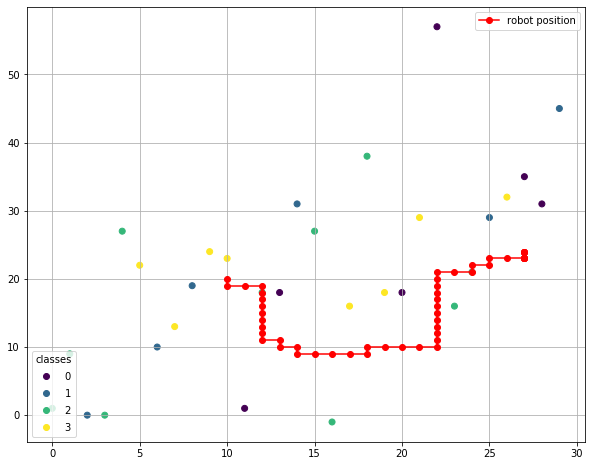

In [53]:
x = np.arange(30)
conduct_experiment(x, mean=3, std=10, k=5, n_movements=50)

**Задание 2.3 (0.01 балл)** Порадуйте ассистента ссылкой на свой любимый фильм/сериал/плейлист👒

"Папа, сдохни" (2018) - крутой [фильм](https://www.kinopoisk.ru/film/1049219/) русского режисера. Камерное кино с гиперболизированным насилием. Не пугайтесь названия.  Говорят, американцы сходят с ума от этого фильма.